In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import Input, Dense, Activation
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import keras

import pandas
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, GaussianNoise
from keras.optimizers import Adam


import pickle
from datetime import datetime

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

/Users/joshfeldman/Harvard/Courses/Fall2019/Capstone/AC297r_2019_somerville_parking/somerville/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
Using TensorFlow backend.


In [2]:
def label_smoother(aerial, gsv):
    mapping = {
        (0, 0): 0,
        (1, 0): 2,
        (2, 0): 0,
        (0, 1): 2,
        (1, 1): 1,
        (2, 1): 1,
        (0, 2): 0,
        (1, 2): 1,
        (2, 2): 2
    }
    return mapping[(int(aerial), int(gsv))]

def clean_labels_redfin(labels):
    labels = labels[['has_parking','MBL']]
    return labels

def clean_labels_hand(labels):
    # smooth labels
    # labels = labels[~((labels['AERIAL_Driveway'] == 2) & (labels['GSV_Driveway'] == 2))]
    labels['final_label']= labels.apply(lambda x: label_smoother(x['AERIAL_Driveway'],x['GSV_Driveway']), axis = 1)
    labels = labels[['final_label', 'MBL']]
    return labels

In [3]:
labels_redfin_path = '../data/redfin_clean.csv'
labels_hand_path = '../data/training/all_labels.csv'
#labels_hand_path_2 = '../data/additional_training_labels_120319.csv'
garage_path = '../data/garage.csv'
tabular_path = '../data/residence_addresses_googlestreetview_clean.csv'

# import dataframe with filenames and labels
labels_redfin = pd.read_csv(labels_redfin_path)
labels_redfin = labels_redfin.fillna(2)

In [4]:
# import data by hand
labels_hand = pd.read_csv(labels_hand_path, index_col = 0)[['MBL','AERIAL_Driveway', 'GSV_Driveway']]
#labels_hand_2 = pd.read_csv(labels_hand_path_2)[['MBL','AERIAL_Driveway', 'GSV_Driveway']]
#labels_hand = pd.concat([labels_hand, labels_hand_2], axis = 0)
labels_hand = labels_hand.fillna(2)

In [5]:
labels_hand

,MBL,AERIAL_Driveway,GSV_Driveway
8041,47-G-17,2.0,0.0
6488,38-A-47,1.0,2.0
7629,44-A-48,2.0,2.0
7669,25-A-13,2.0,2.0
7706,25-D-16,0.0,2.0
965,51-D-1,2.0,2.0
1032,65-C-6,2.0,2.0
7526,81-B-16,2.0,2.0
6214,76-A-19,2.0,2.0
3823,62-C-17,2.0,2.0


In [6]:
labels_hand.columns

Index(['MBL', 'AERIAL_Driveway', 'GSV_Driveway'], dtype='object')

In [7]:
# load garages
garages = pd.read_csv(garage_path, index_col=0)

# load tabular data
tabular = pd.read_csv(tabular_path, index_col = 0)

In [8]:
labels_redfin_clean = clean_labels_redfin(labels_redfin)
labels_hand_clean = clean_labels_hand(labels_hand)

In [20]:
labels_hand_clean.final_label.value_counts()

1    353
0     80
2     67
Name: final_label, dtype: int64

In [9]:
label_count = labels_hand.final_label.value_counts()
percent_driveway = label_count[1]/(label_count[1] + label_count[0]) 
percent_driveway

0.815242494226328

In [10]:
labels_clean = labels_hand_clean.merge(labels_redfin_clean, how = 'outer').merge(garages, how = 'outer')

In [11]:
labels_clean.has_parking = labels_clean.apply(
    lambda row: row.has_parking if not np.isnan(row.has_parking) else 
                row.HAS_GARAGE if not np.isnan(row.HAS_GARAGE) else row.final_label , axis = 1
)
labels_clean = labels_clean.drop(['final_label', 'HAS_GARAGE'], axis = 1)

In [12]:
labels_clean

,MBL,has_parking
0,47-G-17,0.0
1,38-A-47,1.0
2,44-A-48,0.0
3,25-A-13,0.0
4,25-D-16,0.0
...,...,...
6475,94-B-4,1.0
6476,94-D-11,1.0
6477,95-B-1,1.0
6478,95-C-1,1.0


In [13]:
labels_clean.to_csv('../data/labels_final.csv')

In [14]:
def upsample(df):
    # upsample
    n1 = sum((df.has_parking == 1) | (df.has_parking == 0.9))
    n0 = sum((df.has_parking == 0) | (df.has_parking == 0.1))
    labels0 = df[(df.has_parking == 0) | (df.has_parking == 0.1)]
    labels0_upsample = labels0.sample(n1 - n0, replace = True)
    labels_all_upsampled = pd.concat([df, labels0_upsample])
    return labels_all_upsampled

In [15]:
df = labels_clean.merge(tabular)

In [16]:
df.to_csv('../data/df_training.csv')

# EDA

In [14]:
import seaborn as sns
#scaler = StandardScaler()
#df_viz = scaler.fit_transform(df.drop('MBL', axis = 1))
df_viz = pd.DataFrame(df, columns = df.columns.drop(['MBL']))
df_viz = upsample(df_viz)

/Users/joshfeldman/Harvard/Courses/Fall2019/Capstone/AC297r_2019_somerville_parking/somerville/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/joshfeldman/Harvard/Courses/Fall2019/Capstone/AC297r_2019_somerville_parking/somerville/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


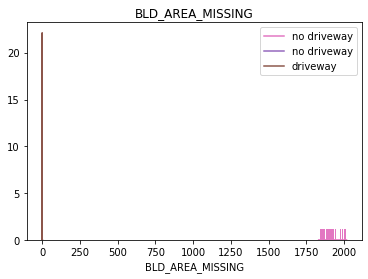

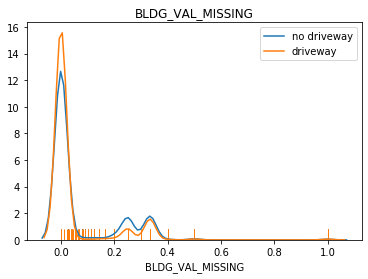

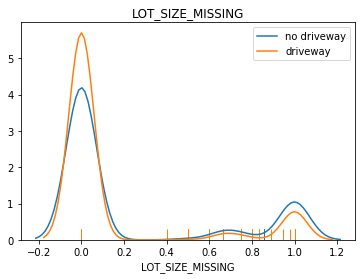

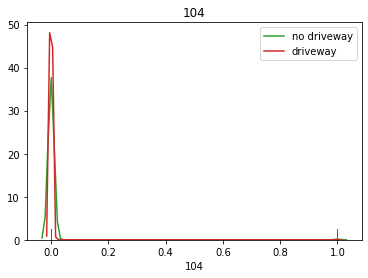

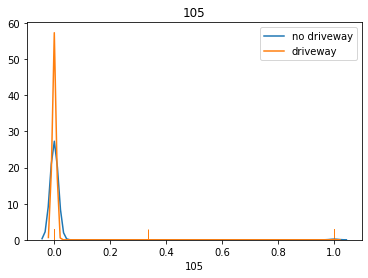

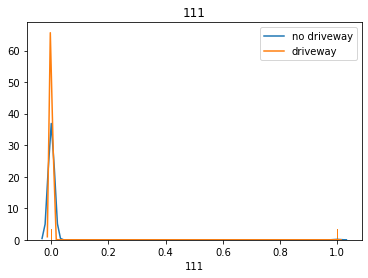

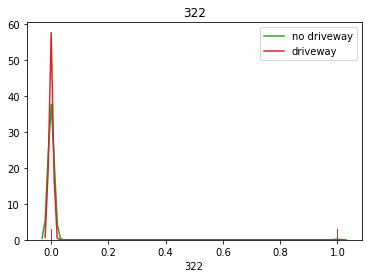

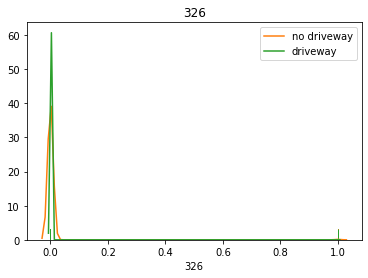

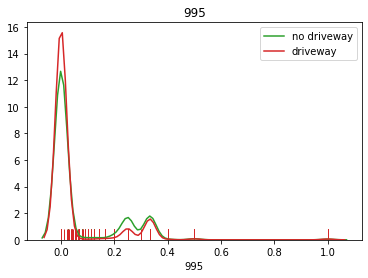

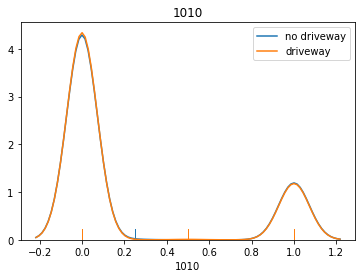

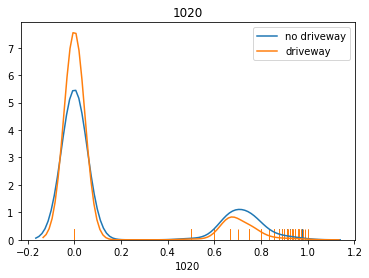

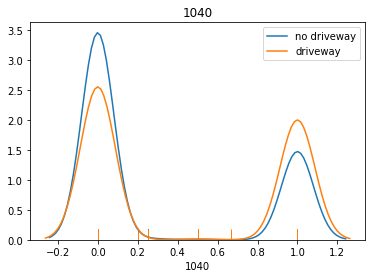

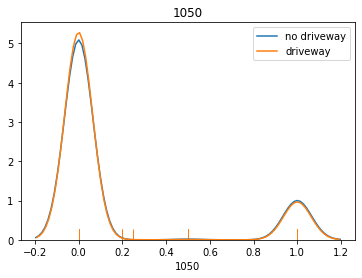

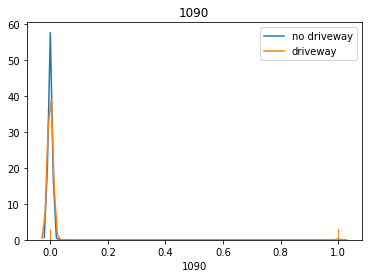

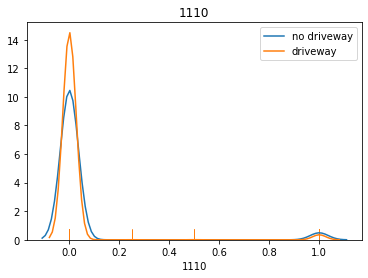

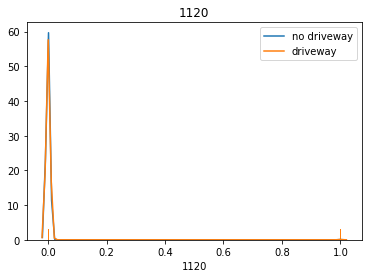

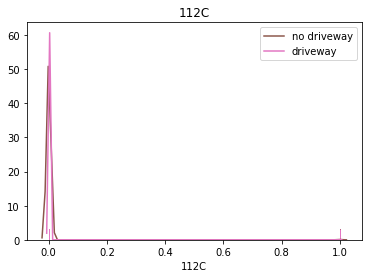

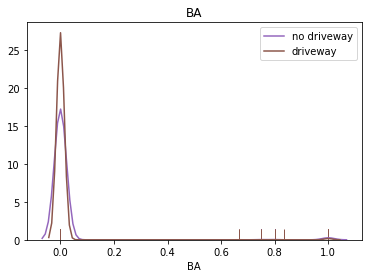

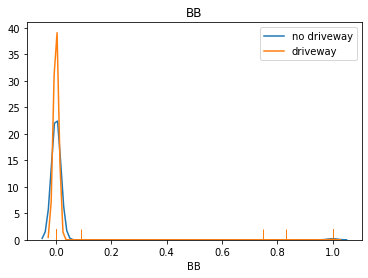

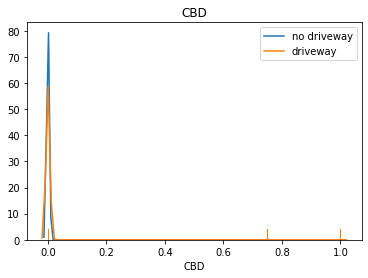

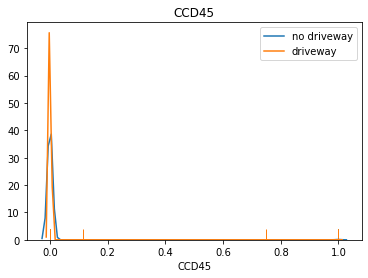

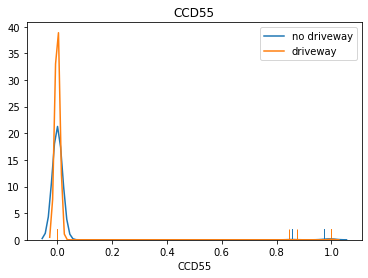

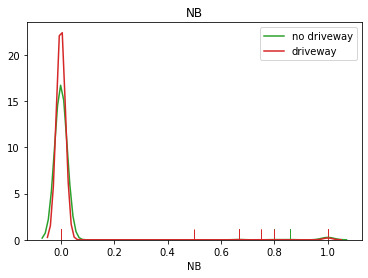

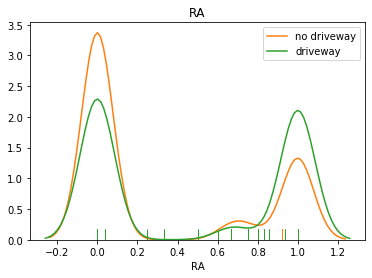

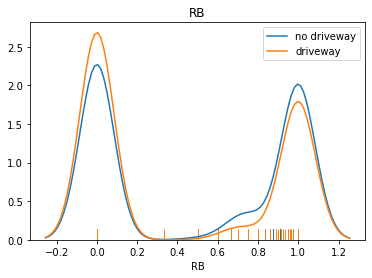

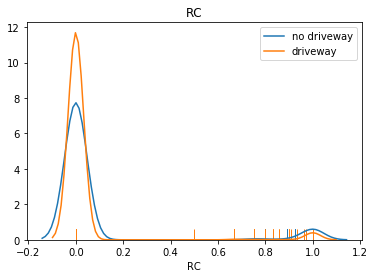

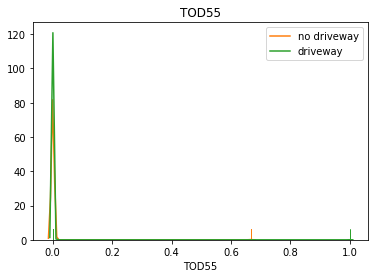

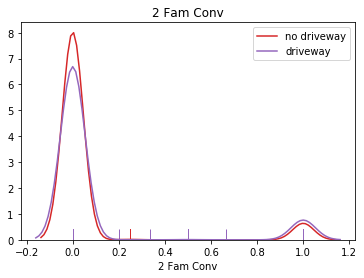

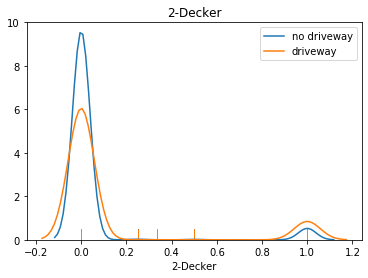

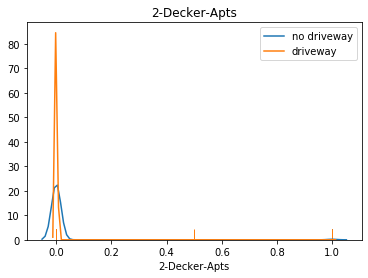

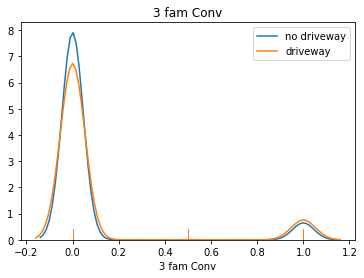

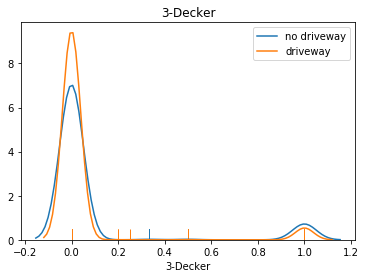

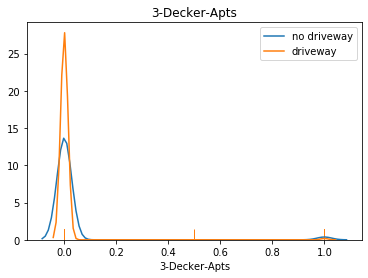

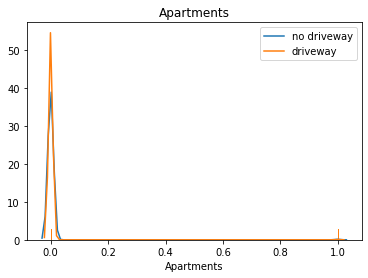

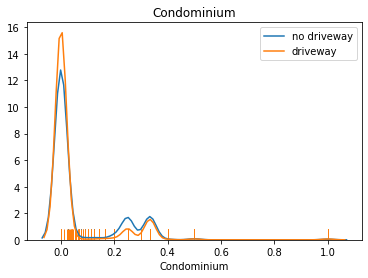

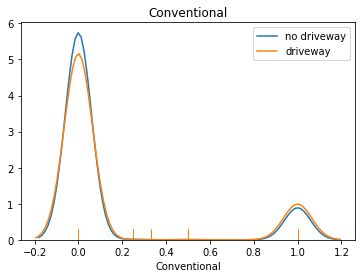

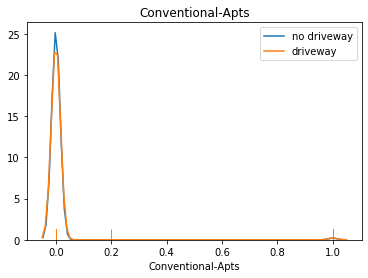

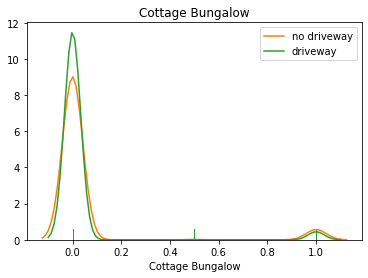

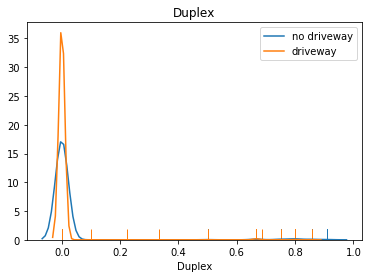

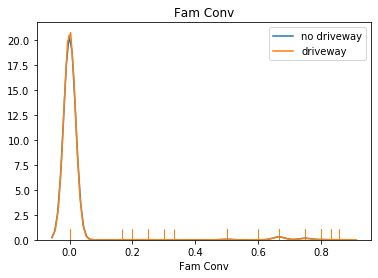

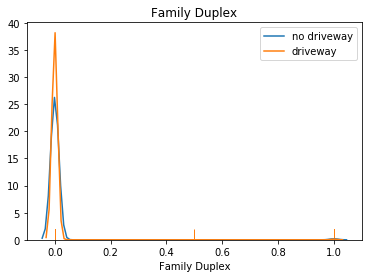

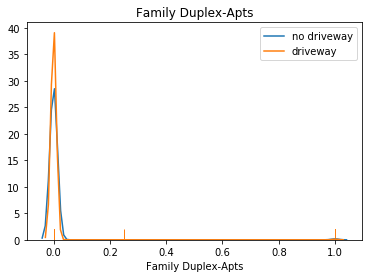

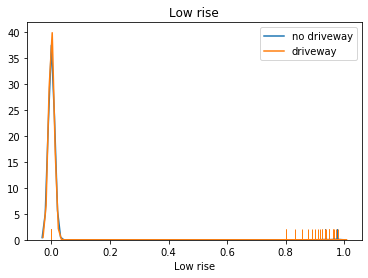

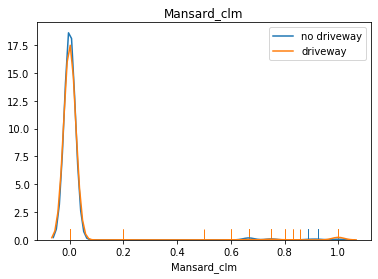

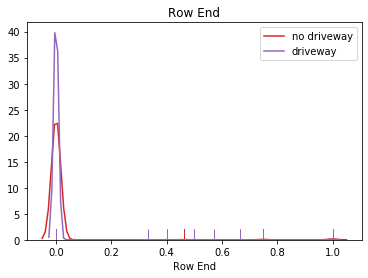

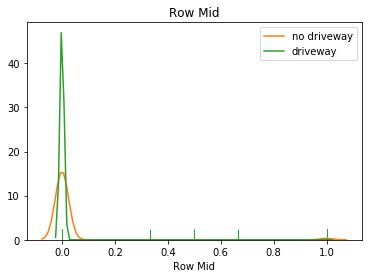

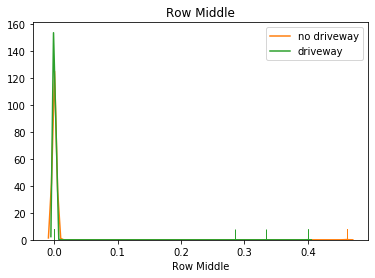

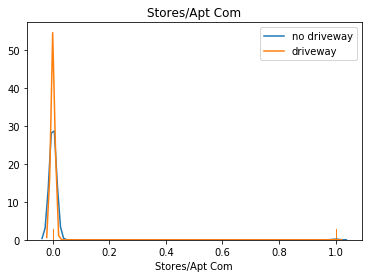

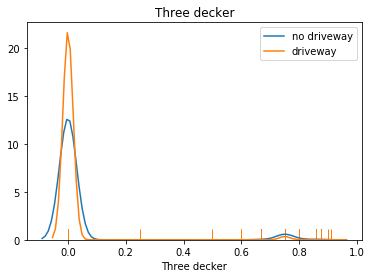

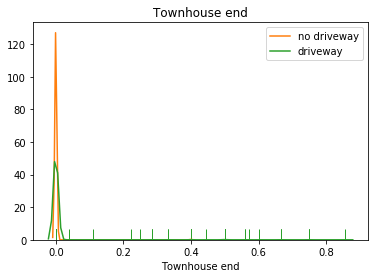

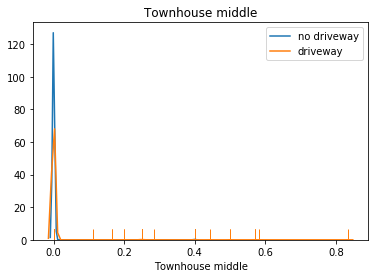

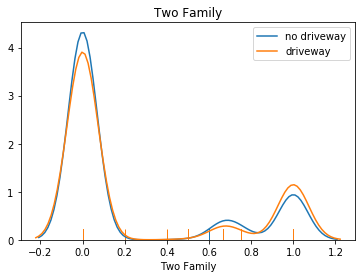

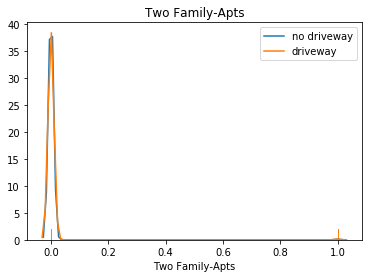

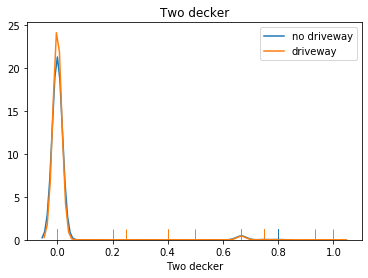

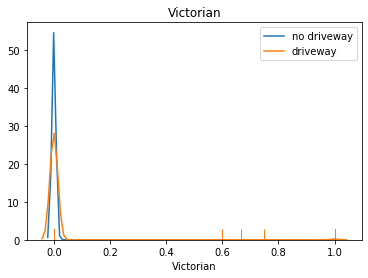

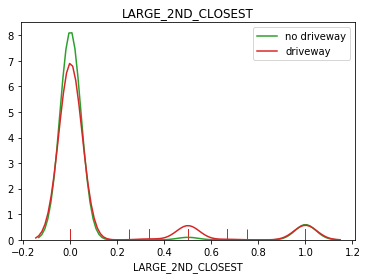

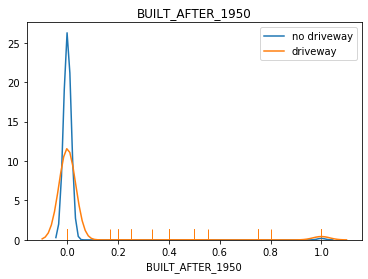

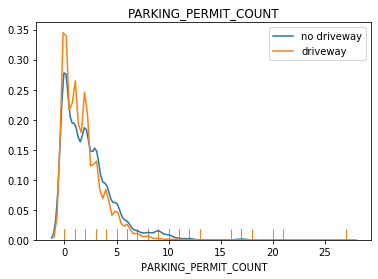

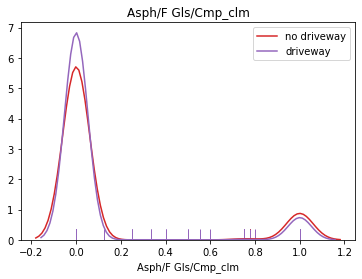

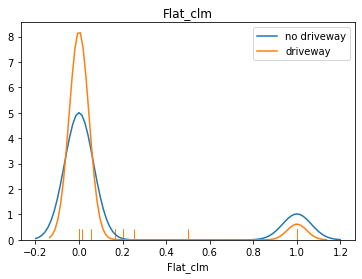

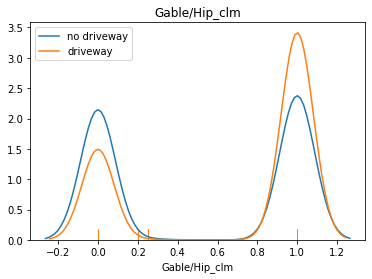

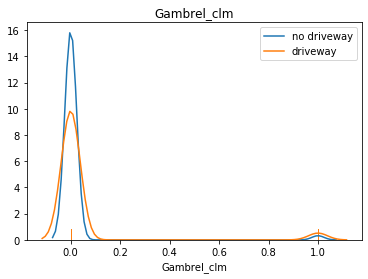

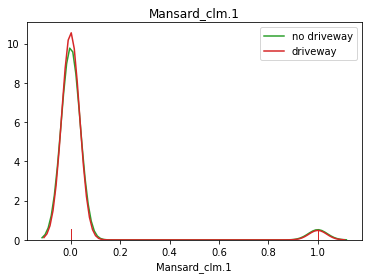

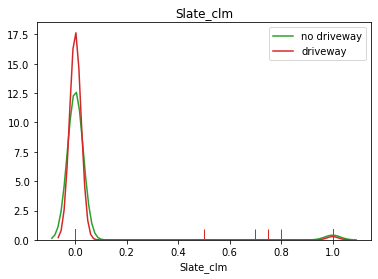

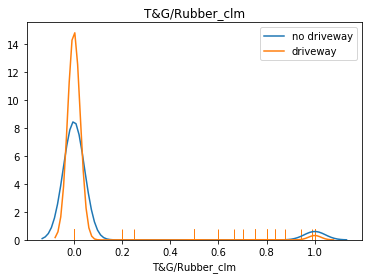

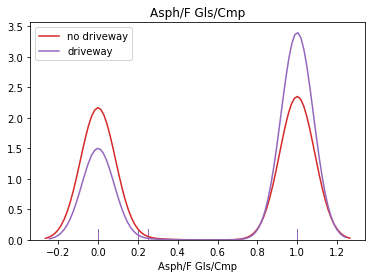

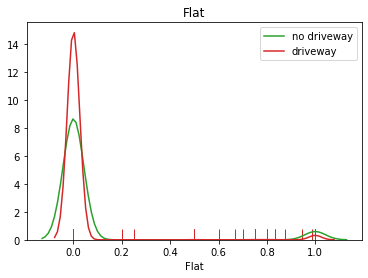

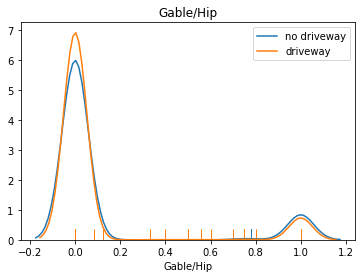

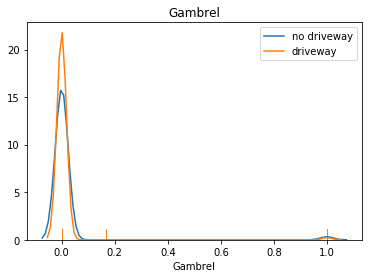

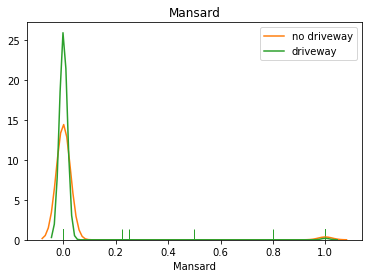

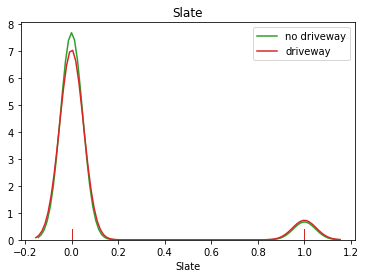

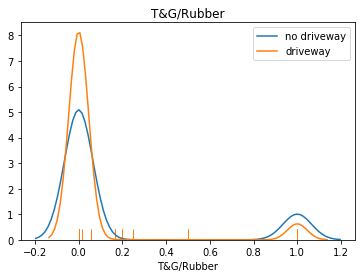

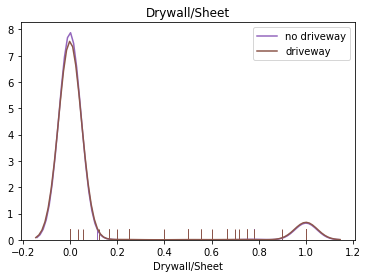

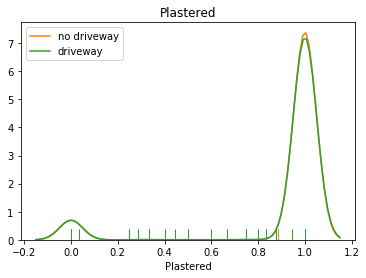

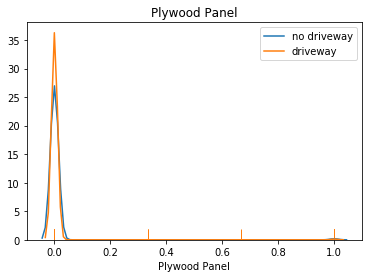

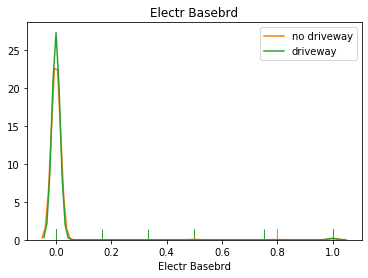

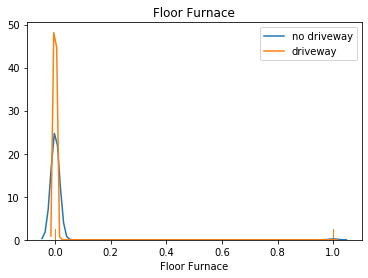

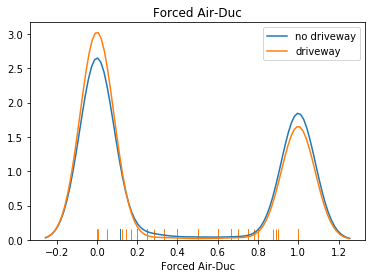

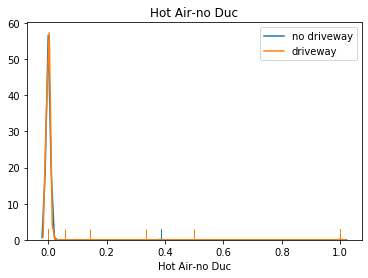

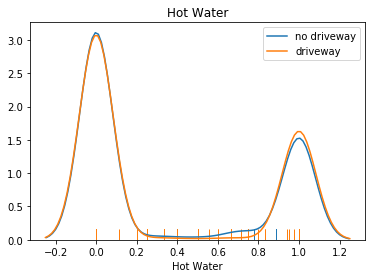

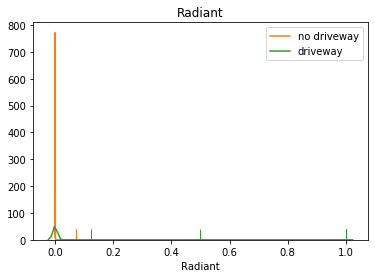

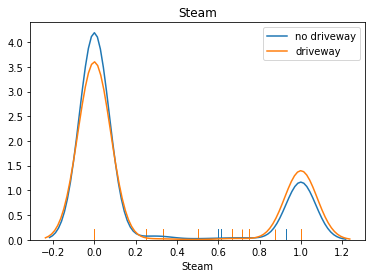

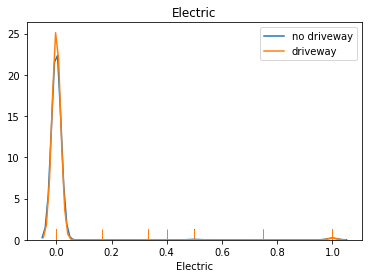

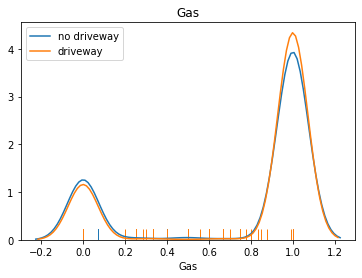

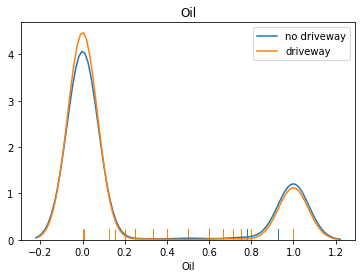

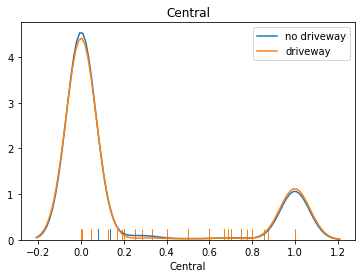

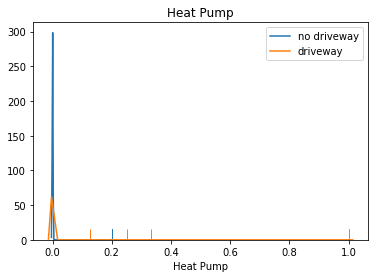

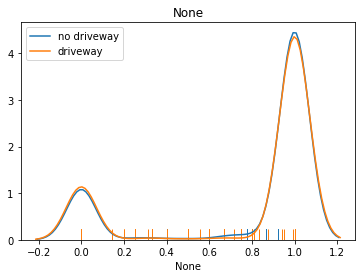

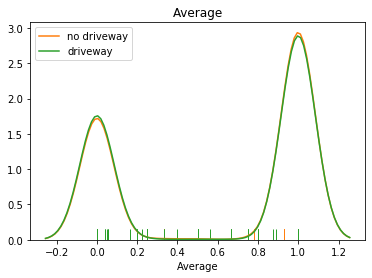

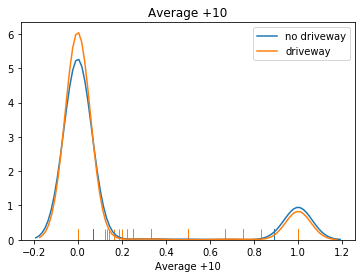

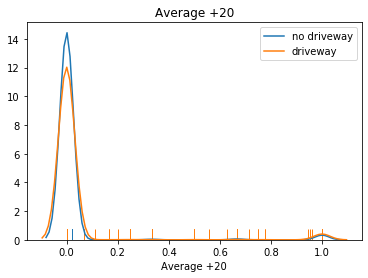

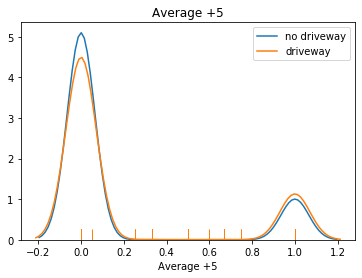

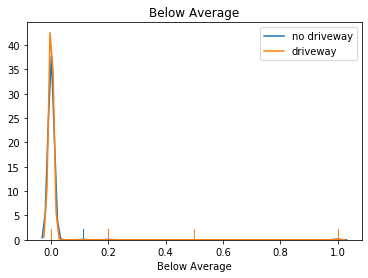

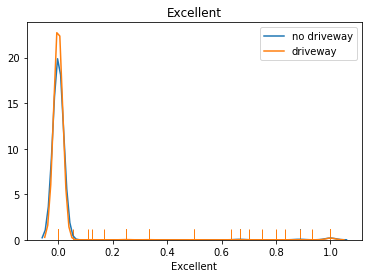

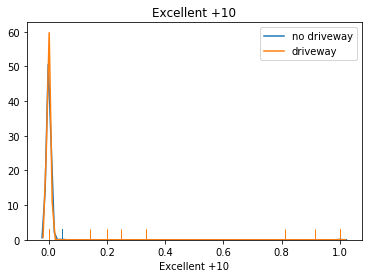

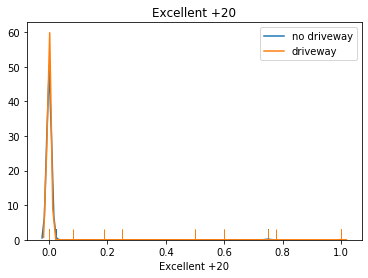

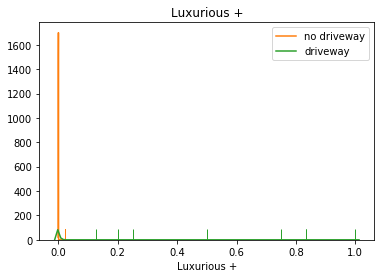

In [217]:
for clm in df_viz.columns:
    try:
        sns.distplot(df_viz[df.has_parking == 0][clm], label = 'no driveway', rug=True, hist=False)
        sns.distplot(df_viz[df.has_parking == 1][clm], label = 'driveway', rug=True, hist=False)
        plt.legend()
        plt.title(clm)
        plt.show()
    except:
        pass

In [218]:
for idx, x in enumerate(df_viz.corr()['has_parking']):
    print(df_viz.corr()['has_parking'].index[idx])
    print(x)

has_parking
1.0
BLDG_VAL
0.003848064001734841
LAND_VAL
0.16218932547962803
OTHER_VAL
0.04415719136218188
LOT_SIZE
0.17197353107579666
LS_PRICE
-0.06046744265564104
YEAR_BUILT
0.08641658953974593
BLD_AREA
0.07986389338049855
UNITS
-0.007782284529048703
RES_AREA
0.049909842193615966
STORIES
0.13416771744621636
NUM_ROOMS
0.06228651175653051
LOT_UNITS
0.07319196539074367
BLD_AREA_MISSING
-0.09070659498196275
BLDG_VAL_MISSING
-0.08934182546657907
LOT_SIZE_MISSING
-0.11332818169367377
101
0.028564979423014777
102
0.012114871047594181
104
-0.029033945994244675
105
-0.040525017390806405
111
-0.0326113249990947
112
0.009029584798095043
130
0.012770303881576307
322
-0.01519920521657621
325
nan
326
-0.03591479641597979
332
nan
340
0.015641028813321287
995
-0.08934182546657907
1010
-0.0050877498217095
1020
-0.11798845763922935
1040
0.1406538260982226
1050
-0.014266602319860284
1090
0.01389460206395169
1110
-0.05524715766464606
1120
0.001875840119191653
1220
0.009029584798092807
9450
0.029563150333

# Prep Data

In [65]:
df = df.fillna(df.mean())

In [66]:
df = df[df.has_parking != 2]

df_train, df_test = train_test_split(df, test_size = 0.2)

df_train_up = upsample(df_train)
df_test_up = upsample(df_test)


X_train, y_train = df_train_up[tabular.columns].drop('MBL', axis = 1), df_train_up['has_parking']
X_test, y_test = df_test_up[tabular.columns].drop('MBL', axis = 1), df_test_up['has_parking']

X_train_original, y_train_original = df_train[tabular.columns].drop('MBL', axis = 1), df_train['has_parking']
X_test_original, y_test_original = df_test[tabular.columns].drop('MBL', axis = 1), df_test['has_parking']

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train_original = scaler.transform(X_train_original)
X_test_original = scaler.transform(X_test_original)


now = datetime.now()

with open(f'../models/scaler_{now}.txt', 'wb') as f:
    pickle.dump(scaler, f)

# poly = PolynomialFeatures(degree = 1)
# X_train = poly.fit_transform(X_train)
# X_test = poly.transform(X_test)

y_test = y_test.apply(lambda x: 1 if x > .5 else 0)
y_train = y_train.apply(lambda x: 1 if x > .5 else 0)
y_train_original = y_train_original.apply(lambda x: 1 if x > .5 else 0)
y_test_original = y_test_original.apply(lambda x: 1 if x > .5 else 0)

In [67]:
X_train.shape

(9508, 175)

In [68]:
y_train.value_counts()

1    4754
0    4754
Name: has_parking, dtype: int64

In [69]:
X_test.shape

(2366, 175)

In [70]:
y_test.value_counts()

1    1183
0    1183
Name: has_parking, dtype: int64

# Logistic Regression

In [71]:
lr = LogisticRegression(C = 1e-3, penalty = 'l2', max_iter = 300)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print('validation stats on upsampled test set:')
# validate on upsampled
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

# validate on original data
print('validation stats on regular test set:')
y_pred_original = lr.predict(X_test_original)
print(confusion_matrix(y_test_original,y_pred_original))
print(classification_report(y_test_original,y_pred_original))

validation stats on upsampled test set:
[[912 271]
 [339 844]]
             precision    recall  f1-score   support

          0       0.73      0.77      0.75      1183
          1       0.76      0.71      0.73      1183

avg / total       0.74      0.74      0.74      2366

validation stats on regular test set:
[[ 89  25]
 [339 844]]
             precision    recall  f1-score   support

          0       0.21      0.78      0.33       114
          1       0.97      0.71      0.82      1183

avg / total       0.90      0.72      0.78      1297



In [226]:
now = datetime.now()

with open(f'../models/logreg_{now}.txt', 'wb') as f:
    pickle.dump(lr, f)

In [227]:
# validate on original certain
# validate on original data
y_pred_original_proba = lr.predict_proba(X_test_original)
y_pred_original = lr.predict(X_test_original)
threshold = .2
is_certain_pred = np.absolute(y_pred_original_proba[:,1] - 0.5) > threshold
print(classification_report(y_test_original[is_certain_pred],y_pred_original[is_certain_pred]))
print(sum(is_certain_pred)/len(is_certain_pred))

             precision    recall  f1-score   support

          0       0.32      0.90      0.47        52
          1       0.99      0.83      0.90       594

avg / total       0.94      0.83      0.87       646

0.5054773082942097


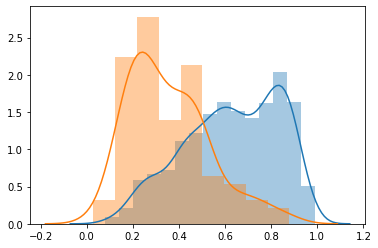

In [228]:
import seaborn as sns
sns.distplot(y_pred_original_proba[:,1][y_test_original == 1])
sns.distplot(y_pred_original_proba[:,1][y_test_original == 0])

In [229]:
param_dict = dict(zip(df_test[tabular.columns].drop('MBL', axis = 1).columns, lr.coef_.reshape(-1)))

param_dict

{'BLDG_VAL': 0.05272681944100839,
 'LAND_VAL': 0.1258292637917792,
 'OTHER_VAL': 0.008481820145033393,
 'LOT_SIZE': 0.08805086842936591,
 'LS_PRICE': -0.09664927589885895,
 'YEAR_BUILT': 0.049420351529905336,
 'BLD_AREA': 0.06667224681986776,
 'UNITS': -0.022043402733505087,
 'RES_AREA': 0.04953781194360867,
 'STORIES': 0.10416044836850094,
 'NUM_ROOMS': 0.09644042166770488,
 'LOT_UNITS': -0.024281000053408476,
 'BLD_AREA_MISSING': -0.06564487382203012,
 'BLDG_VAL_MISSING': -0.01538162141637672,
 'LOT_SIZE_MISSING': -0.027708434780363077,
 '101': 0.04502641459417394,
 '102': 0.002769485504386463,
 '104': -0.0831678132034174,
 '105': -0.010097900229273564,
 '111': 0.0011860740269027945,
 '112': 0.005344560693565134,
 '130': 0.02178015355569204,
 '322': -0.013964285620238824,
 '325': 0.0,
 '326': -0.05050493567091334,
 '332': 0.0,
 '340': 0.03146561035253801,
 '995': -0.01538162141637672,
 '1010': -0.017751772736237164,
 '1020': -0.012801817472114663,
 '1040': 0.01942244397516041,
 '1050

## Logistic Regression w/ Interactions

In [72]:
# select features for interaction with lasso
lr = LogisticRegression(C = 0.006, penalty = 'l1', max_iter = 300, solver = 'liblinear')
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
# validate on upsampled
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

# validate on original data
print('validation stats on regular test set:')
y_pred_original = lr.predict(X_test_original)
print(confusion_matrix(y_test_original,y_pred_original))
print(classification_report(y_test_original,y_pred_original))

interaction_columns = [clm 
                       for idx, clm in enumerate(df_test[tabular.columns].drop('MBL', axis = 1)) 
                       if lr.coef_.reshape(-1)[idx] > 0]

training_clms = df_train_up[tabular.columns].drop('MBL', axis = 1).columns
interaction_clms_idx = [idx for idx, clm in enumerate(training_clms) if clm in interaction_columns]
non_interaction_clms_idx = [idx for idx, clm in enumerate(training_clms) if clm not in interaction_columns]

[[977 206]
 [377 806]]
             precision    recall  f1-score   support

          0       0.72      0.83      0.77      1183
          1       0.80      0.68      0.73      1183

avg / total       0.76      0.75      0.75      2366

validation stats on regular test set:
[[ 95  19]
 [377 806]]
             precision    recall  f1-score   support

          0       0.20      0.83      0.32       114
          1       0.98      0.68      0.80      1183

avg / total       0.91      0.69      0.76      1297



In [231]:
poly = PolynomialFeatures(degree = 2)
X_train_interact = poly.fit_transform(X_train[:,interaction_clms_idx])
X_test_interact = poly.transform(X_test[:,interaction_clms_idx])
X_test_original_interact = poly.transform(X_test_original[:,interaction_clms_idx])


X_train_interact = np.concatenate([X_train_interact, X_train[:,non_interaction_clms_idx]], axis = 1)
X_test_interact = np.concatenate([X_test_interact, X_test[:,non_interaction_clms_idx]], axis = 1)
X_test_original_interact = np.concatenate([X_test_original_interact, X_test_original[:,non_interaction_clms_idx]], axis = 1)

In [232]:
X_train_interact.shape

(9376, 281)

In [233]:
lr = LogisticRegression(C = 0.003, penalty = 'l2', max_iter = 300)
lr.fit(X_train_interact, y_train)

# validate on upsampled
y_pred = lr.predict(X_test_interact)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

# validate on original data
y_pred_original = lr.predict(X_test_original_interact)
print(confusion_matrix(y_test_original,y_pred_original))
print(classification_report(y_test_original,y_pred_original))

[[979 200]
 [324 855]]
             precision    recall  f1-score   support

          0       0.75      0.83      0.79      1179
          1       0.81      0.73      0.77      1179

avg / total       0.78      0.78      0.78      2358

[[ 82  17]
 [324 855]]
             precision    recall  f1-score   support

          0       0.20      0.83      0.32        99
          1       0.98      0.73      0.83      1179

avg / total       0.92      0.73      0.79      1278



In [234]:
sum(y_test == y_pred)/len(y_test==y_pred)

0.7777777777777778

# Support Vector Machine

In [235]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='rbf')
svclassifier.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [236]:
y_pred = svclassifier.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

y_pred_original = svclassifier.predict(X_test_original)
print(confusion_matrix(y_test_original, y_pred_original))
print(classification_report(y_test_original, y_pred_original))

[[776 403]
 [241 938]]
             precision    recall  f1-score   support

          0       0.76      0.66      0.71      1179
          1       0.70      0.80      0.74      1179

avg / total       0.73      0.73      0.73      2358

[[ 63  36]
 [241 938]]
             precision    recall  f1-score   support

          0       0.21      0.64      0.31        99
          1       0.96      0.80      0.87      1179

avg / total       0.90      0.78      0.83      1278



In [237]:
now = datetime.now()

with open(f'../models/svc_{now}.txt', 'wb') as f:
    pickle.dump(svclassifier, f)

# XGBoost

In [238]:
#Import libraries:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import metrics   #Additional scklearn functions
from sklearn.model_selection import GridSearchCV   #Perforing grid search

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

In [239]:
try:
    df = df.drop(['MBL','AERIAL_Driveway', 'GSV_Driveway'], axis = 1)
except KeyError:
    pass

df.has_parking = df.has_parking.apply(lambda x: 1 if x > .5 else 0)

train = df
target = 'has_parking'
IDcol = 'MBL'

In [36]:
count = train.has_parking.value_counts()
scale = count[0]/count[1]
scale

0.09269923834293145

In [37]:
def modelfit(alg, dtrain, predictors, cv_folds=5, early_stopping_rounds=300):
    xgb_param = alg.get_xgb_params()
    xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
    cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
        metrics='auc', early_stopping_rounds=early_stopping_rounds)
    alg.set_params(n_estimators=cvresult.shape[0])
    print(cvresult.shape[0])
    return cvresult.shape[0]

In [38]:
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=scale,
 seed=27)

predictors = [x for x in train.columns if x not in [target, IDcol]]
best_n_estimators = modelfit(xgb1, train, predictors)

59


In [39]:
param_test1 = {
 'max_depth':[2,3,4],
 'min_child_weight':[5,6,7]
}

gsearch1 = (
    GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=best_n_estimators, max_depth=5,
                 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                 objective= 'binary:logistic', nthread=4, scale_pos_weight=scale, seed=27), 
    param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
)
gsearch1.fit(train[predictors],train[target])
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

KeyboardInterrupt: 

In [ ]:
gsearch1.best_params_

In [ ]:
param_test2 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch2 = GridSearchCV(
    estimator = XGBClassifier( 
        learning_rate =0.1, 
        n_estimators=best_n_estimators, 
        max_depth=gsearch1.best_params_['max_depth'],
        min_child_weight=gsearch1.best_params_['min_child_weight'], 
        gamma=0, 
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic', 
        nthread=4, 
        scale_pos_weight=scale,
        seed=27), 
    param_grid = param_test2, 
    scoring='roc_auc',
    n_jobs=4,
    iid=False,
    cv=5
)
gsearch2.fit(train[predictors],train[target])
gsearch2.cv_results_, gsearch2.best_params_, gsearch2.best_score_

In [ ]:
xgb2 = XGBClassifier(
    learning_rate =0.1, 
    n_estimators=1000, 
    max_depth=gsearch1.best_params_['max_depth'],
    min_child_weight=gsearch1.best_params_['min_child_weight'], 
    gamma=gsearch2.best_params_['gamma'], 
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic', 
    nthread=4, 
    scale_pos_weight=scale,
    seed=27
)
best_n_estimators = modelfit(xgb2, train, predictors)

In [ ]:
xgb3 = XGBClassifier(
    learning_rate =0.1, 
    n_estimators=best_n_estimators, 
    max_depth=gsearch1.best_params_['max_depth'],
    min_child_weight=gsearch1.best_params_['min_child_weight'], 
    gamma=gsearch2.best_params_['gamma'], 
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic', 
    nthread=4, 
    scale_pos_weight=scale,
    seed=27
)

In [ ]:
# fit model
train, test = train_test_split(df, test_size = 0.2)

In [ ]:
xgb3.fit(train[predictors], train[target])
y_pred = xgb3.predict(test[predictors])
sum(y_pred == test[target])/len(test[target])

In [ ]:
y_pred = xgb3.predict(test[predictors])
print(classification_report(test[target],y_pred))

# Neural Network

In [177]:
batch_size = 16
epochs = 40
layers = 6

model = Sequential()
model.add(GaussianNoise(0.1, input_shape = (X_train.shape[1], )))
for _ in range(layers):
    model.add(Dense(50, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(BatchNormalization())
    # model.add(Activation('relu'))
    model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
# Compile model
adam = Adam(lr = 1e-4)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_test, y_test))
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gaussian_noise_8 (GaussianNo (None, 172)               0         
_________________________________________________________________
dense_40 (Dense)             (None, 50)                8650      
_________________________________________________________________
batch_normalization_33 (Batc (None, 50)                200       
_________________________________________________________________
dropout_33 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_41 (Dense)             (None, 50)                2550      
_________________________________________________________________
batch_normalization_34 (Batc (None, 50)                200       
_________________________________________________________________
dropout_34 (Dropout)         (None, 50)               

9240/9240 [==============================] - 3s 339us/step - loss: 0.4597 - accuracy: 0.8245 - val_loss: 0.5888 - val_accuracy: 0.7554
Epoch 37/40
9240/9240 [==============================] - 3s 320us/step - loss: 0.4613 - accuracy: 0.8213 - val_loss: 0.6083 - val_accuracy: 0.7359
Epoch 38/40
9240/9240 [==============================] - 3s 329us/step - loss: 0.4642 - accuracy: 0.8210 - val_loss: 0.5869 - val_accuracy: 0.7567
Epoch 39/40
9240/9240 [==============================] - 3s 316us/step - loss: 0.4569 - accuracy: 0.8246 - val_loss: 0.5762 - val_accuracy: 0.7589
Epoch 40/40
9240/9240 [==============================] - 3s 332us/step - loss: 0.4595 - accuracy: 0.8245 - val_loss: 0.6082 - val_accuracy: 0.7498
Test loss: 0.6081631100653362
Test accuracy: 0.7497831583023071


## Random Forest

In [77]:
from sklearn.model_selection import GridSearchCV

In [78]:
params = {
    'bootstrap' : [True, False],
    'n_estimators' : [16, 64, 256, 1024],
    'max_depth' : [3,4,5,6]
}

rf_up = GridSearchCV(RandomForestClassifier(), params, n_jobs = -1, verbose = 2)

In [79]:
rf_up.fit(X_train, y_train)
y_pred = rf_up.predict(X_test)

print('validation stats on upsampled test set:')
# validate on upsampled
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

# validate on original data
print('validation stats on regular test set:')
y_pred_original = rf_up.predict(X_test_original)
print(confusion_matrix(y_test_original,y_pred_original))
print(classification_report(y_test_original,y_pred_original))

Fitting 3 folds for each of 32 candidates, totalling 96 fits
[CV] bootstrap=True, max_depth=3, n_estimators=16 ....................
[CV] bootstrap=True, max_depth=3, n_estimators=16 ....................
[CV] bootstrap=True, max_depth=3, n_estimators=16 ....................
[CV] bootstrap=True, max_depth=3, n_estimators=64 ....................
[CV] ..... bootstrap=True, max_depth=3, n_estimators=16, total=   0.3s
[CV] bootstrap=True, max_depth=3, n_estimators=64 ....................
[CV] ..... bootstrap=True, max_depth=3, n_estimators=16, total=   0.3s
[CV] bootstrap=True, max_depth=3, n_estimators=64 ....................
[CV] ..... bootstrap=True, max_depth=3, n_estimators=16, total=   0.3s
[CV] bootstrap=True, max_depth=3, n_estimators=256 ...................
[CV] ..... bootstrap=True, max_depth=3, n_estimators=64, total=   0.8s
[CV] bootstrap=True, max_depth=3, n_estimators=256 ...................
[CV] ..... bootstrap=True, max_depth=3, n_estimators=64, total=   0.8s
[CV] ..... boots

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   44.8s


[CV] ..... bootstrap=True, max_depth=6, n_estimators=16, total=   0.6s
[CV] bootstrap=True, max_depth=6, n_estimators=16 ....................
[CV] ..... bootstrap=True, max_depth=6, n_estimators=16, total=   0.5s
[CV] bootstrap=True, max_depth=6, n_estimators=16 ....................
[CV] ..... bootstrap=True, max_depth=6, n_estimators=16, total=   0.5s
[CV] bootstrap=True, max_depth=6, n_estimators=64 ....................
[CV] ..... bootstrap=True, max_depth=6, n_estimators=64, total=   1.6s
[CV] bootstrap=True, max_depth=6, n_estimators=64 ....................
[CV] ..... bootstrap=True, max_depth=6, n_estimators=64, total=   1.5s
[CV] bootstrap=True, max_depth=6, n_estimators=64 ....................
[CV] ..... bootstrap=True, max_depth=6, n_estimators=64, total=   2.2s
[CV] bootstrap=True, max_depth=6, n_estimators=256 ...................
[CV] .... bootstrap=True, max_depth=6, n_estimators=256, total=   3.0s
[CV] bootstrap=True, max_depth=6, n_estimators=256 ...................
[CV] .

[CV] .. bootstrap=False, max_depth=5, n_estimators=1024, total=  12.3s
[CV] bootstrap=False, max_depth=6, n_estimators=1024 .................
[CV] ... bootstrap=False, max_depth=6, n_estimators=256, total=   3.5s
[CV] .. bootstrap=False, max_depth=6, n_estimators=1024, total=  11.6s
[CV] .. bootstrap=False, max_depth=6, n_estimators=1024, total=  11.4s
[CV] .. bootstrap=False, max_depth=6, n_estimators=1024, total=  11.4s


[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:  2.4min finished


validation stats on upsampled test set:
[[812 371]
 [280 903]]
             precision    recall  f1-score   support

          0       0.74      0.69      0.71      1183
          1       0.71      0.76      0.74      1183

avg / total       0.73      0.72      0.72      2366

validation stats on regular test set:
[[ 80  34]
 [280 903]]
             precision    recall  f1-score   support

          0       0.22      0.70      0.34       114
          1       0.96      0.76      0.85      1183

avg / total       0.90      0.76      0.81      1297



In [297]:
sum(y_test==y_pred)/len(y_test==y_pred)

0.7782018659881256

In [295]:
rf_up.best_params_

{'bootstrap': False, 'max_depth': 6, 'n_estimators': 256}

In [243]:
y_pred = rf_up.predict(X_test)
y_pred_proba = rf_up.predict_proba(X_test)
certain = y_pred_proba[:,1] > 0.6

print('validation stats on upsampled test set:')
# validate on upsampled
print(confusion_matrix(y_test[certain], y_pred[certain]))
print(classification_report(y_test[certain], y_pred[certain]))

validation stats on upsampled test set:
[[  0  50]
 [  0 695]]
             precision    recall  f1-score   support

          0       0.00      0.00      0.00        50
          1       0.93      1.00      0.97       695

avg / total       0.87      0.93      0.90       745



/Users/joshfeldman/Harvard/Courses/Fall2019/Capstone/AC297r_2019_somerville_parking/somerville/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [244]:
with open(f'../models/random_forest_{now}.txt', 'wb') as f:
    pickle.dump(rf_up, f)

(array([210., 244., 289., 319., 265., 185., 247., 127., 153., 267.]),
 array([0.18418892, 0.2599896 , 0.33579027, 0.41159094, 0.48739161,
        0.56319228, 0.63899295, 0.71479363, 0.7905943 , 0.86639497,
        0.94219564]),
 <a list of 10 Patch objects>)

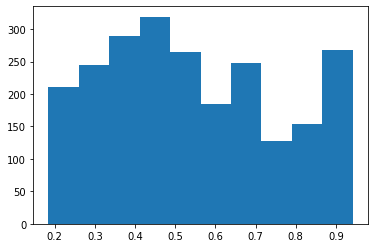

In [202]:
plt.hist(y_pred_proba[:,1])

In [203]:
rf_up.predict(X_test[0:,:])

array([1, 1, 1, ..., 1, 1, 1])

(array([0.13333333, 0.0755814 , 0.20809249, 0.36787565, 0.51963746,
       0.63013699, 0.85555556, 0.9581749 , 1.        ]), array([0.19087887, 0.25370111, 0.35461318, 0.44894375, 0.54195127,
       0.65575154, 0.74084693, 0.85618007, 0.91442741]))


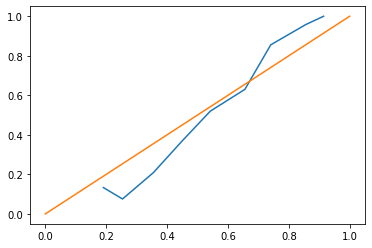

In [204]:
from sklearn.calibration import calibration_curve
res = calibration_curve(y_test, y_pred_proba[:,1], n_bins=10)
print(res)
plt.plot(res[1], res[0])
plt.plot(np.linspace(0,1,20), np.linspace(0,1,20))

## Stacking

In [ ]:
from sklearn.ensemble import StackingClassifier

models = [('rf', rf_up),('svc', svclassifier), ('lr',lr)]

stack = StackingClassifier(models)
stack.fit(X_train, y_train)
y_pred = stack.predict(X_test)

In [ ]:
print('validation stats on upsampled test set:')
# validate on upsampled
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

# validate on original data
print('validation stats on regular test set:')
y_pred_original = stack.predict(X_test_original)
print(confusion_matrix(y_test_original,y_pred_original))
print(classification_report(y_test_original,y_pred_original))

## Make Predictions

In [251]:
tabular_no_mbl = tabular.drop('MBL', axis =1)
tabular_no_na = tabular_no_mbl.fillna(tabular_no_mbl.mean())
y_prob = rf_up.predict_proba(scaler.transform(tabular_no_na))

In [252]:
predictions_all = pd.DataFrame()
predictions_all['MBL'] = tabular['MBL']
predictions_all['no_driveway'] = y_prob[:,0]
predictions_all['yes_driveway'] = y_prob[:,1]

In [256]:
predictions_all.to_csv('../data/predictions_final.csv')

## Feature Importances

In [263]:
features = df.drop(['MBL','has_parking'], axis = 1).columns

importances = rf_up.best_estimator_.feature_importances_

feature_imp = dict(zip(features, importances))

import operator
sorted(feature_imp.items(), key=operator.itemgetter(1), reverse = True)[:20]
pd.DataFrame(sorted(feature_imp.items(), key=operator.itemgetter(1), reverse = True)[:20]).to_csv('../data/feature_imp.csv')